In [1]:
import os
import glob
import cv2
import numpy as np
import random
from adjustText import adjust_text
import plotly.express as px
from tifffile import TiffFile
import os
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)

base_dir = r"N:\00_Exchange\Alois\data\data_processed"
os.chdir(r"N:\\00_Exchange\\Alois")



In [16]:
import os
import pandas as pd
import numpy as np
import cv2
from tifffile import TiffFile

def read_tif(file_path):
    """Read a TIFF file and return it as a numpy array."""
    layers_vessel = []
    with TiffFile(file_path) as tif:
        for page in tif.pages:
            layer = page.asarray()
            layers_vessel.append(layer)
    image = np.stack(layers_vessel)
    return image

def equalize_contrast(image):
    """Apply histogram equalization to each layer of the image."""
    for i in range(image.shape[0]):
        image[i] = cv2.equalizeHist(image[i])
    return image

def threshold_image(image, lower_bound, upper_bound):
    """Threshold the image to keep values within the specified bounds."""
    return cv2.inRange(image, lower_bound, upper_bound)

def compute_leakage(thresholded_image, vessel_mask, retina_mask):
    """Compute the leakage by subtracting the vessel mask and applying the retina mask."""
    leakage_image = cv2.subtract(thresholded_image, vessel_mask)
    leakage_image = cv2.bitwise_and(leakage_image, leakage_image, mask=retina_mask)
    return leakage_image

def process_data(data_dir):
    treatments = ['PBS', '11C7', 'NG004', 'FG12']
    results = []

    for treatment in treatments:
        raw_dir = os.path.join(data_dir, treatment)
        processed_dir = os.path.join(data_dir, 'data_processed', treatment)
        mask_dir = os.path.join(data_dir, 'retina_masks', treatment)

        for subject_file in os.listdir(raw_dir):
            if subject_file.endswith('.tif'):
                subject_id, eye, _ = subject_file.split('_')
                raw_path = os.path.join(raw_dir, subject_file)
                processed_path = os.path.join(processed_dir, f"{subject_id}_{eye}_25x", f"{subject_id}_{eye}_25x_reconstructed_multi.tif")
                mask_path = os.path.join(mask_dir, f"{subject_id}_{eye}_25x_mask.tif")

                raw_image = read_tif(raw_path)
                vessel_mask = read_tif(processed_path)
                retina_mask = read_tif(mask_path)

                raw_image_eq = equalize_contrast(raw_image)

                for layer_number in range(raw_image_eq.shape[0]):
                    thresholded_image = threshold_image(raw_image_eq[layer_number], 140, 255)
                    leakage_image = compute_leakage(thresholded_image, vessel_mask[layer_number], retina_mask[layer_number])
                    leakage_count = np.sum(leakage_image > 0)
                    total_retina_area = np.sum(retina_mask[layer_number] > 0)
                    leakage_fraction = leakage_count / total_retina_area if total_retina_area else 0

                    results.append({
                        'Treatment': treatment,
                        'Eye': eye,
                        'LayerNumber': layer_number,
                        'LeakageFrac': leakage_fraction,
                        'SubjectID': subject_id
                    })

    df = pd.DataFrame(results)
    return df

data_dir = 'data_full'
df = process_data(data_dir)


In [17]:
df['SubjectID'] = df['SubjectID'].str.extract(r'Akita(\d+)')



In [18]:
df.to_csv('255_leakage_fraction_layers.csv', index=False)


In [19]:
df = pd.read_csv('255_leakage_fraction_layers.csv')


In [20]:
df_alignment = pd.read_csv('alignment_layers.csv')

In [21]:

df_merged = pd.merge(df, df_alignment, on=['SubjectID', 'Eye', 'Treatment', 'LayerNumber'], how='left')
df_merged['LayerNumber'] = df_merged['AlignedLayerNumber']

if df_merged['AlignedLayerNumber'].isna().any():
    print("There are unmatched rows where AlignedLayerNumber is NaN")
df = df_merged.drop(columns='AlignedLayerNumber')





In [22]:
df.to_csv(r'E:\Retina-Segmentation\Analysis\Analysis Full\255_leakage_fraction_layers.csv', index=False)


In [2]:
df = pd.read_csv(r'E:\Retina-Segmentation\Analysis\Analysis Full\255_leakage_fraction_layers.csv')

## Plots

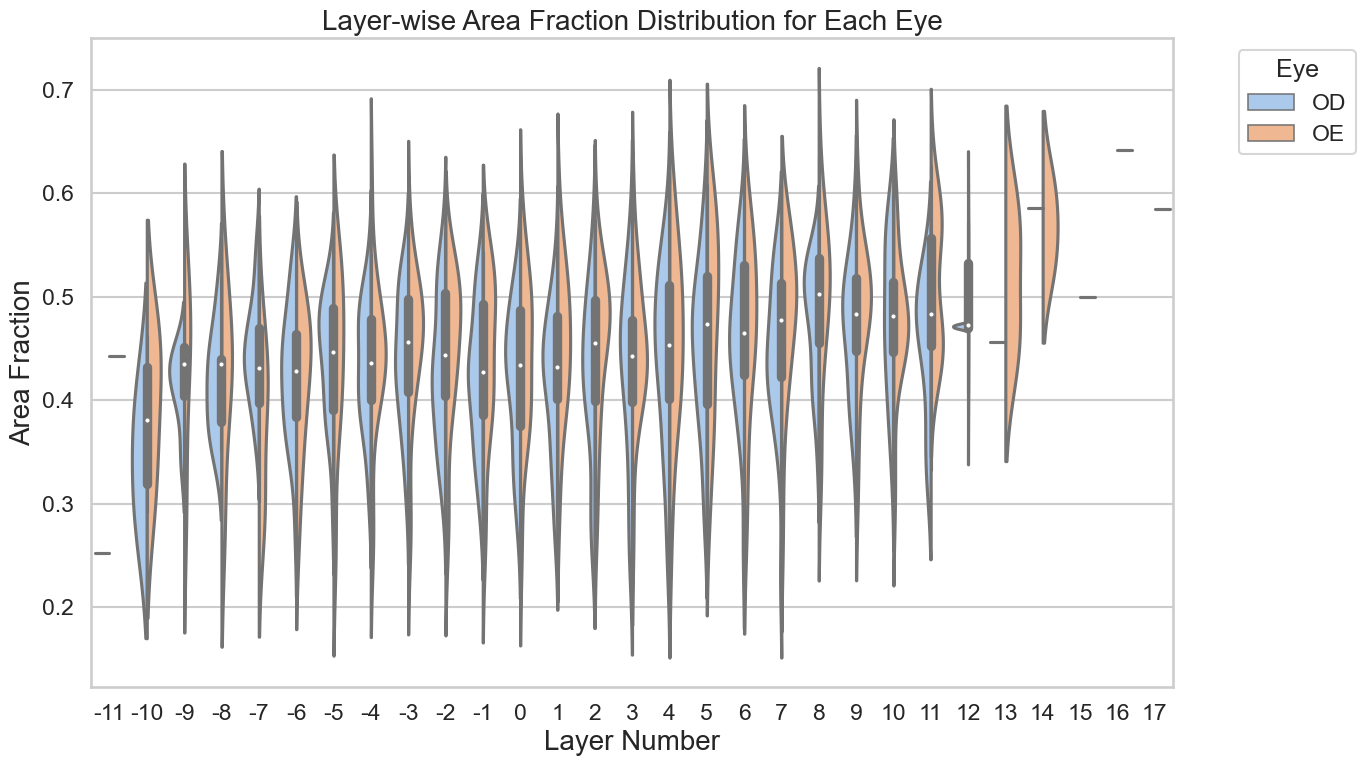

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

violin_plot = sns.violinplot(x="LayerNumber", y="LeakageFrac", hue="Eye", data=df, palette="pastel", split=True)

plt.title('Layer-wise Area Fraction Distribution for Each Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)
plt.legend(title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


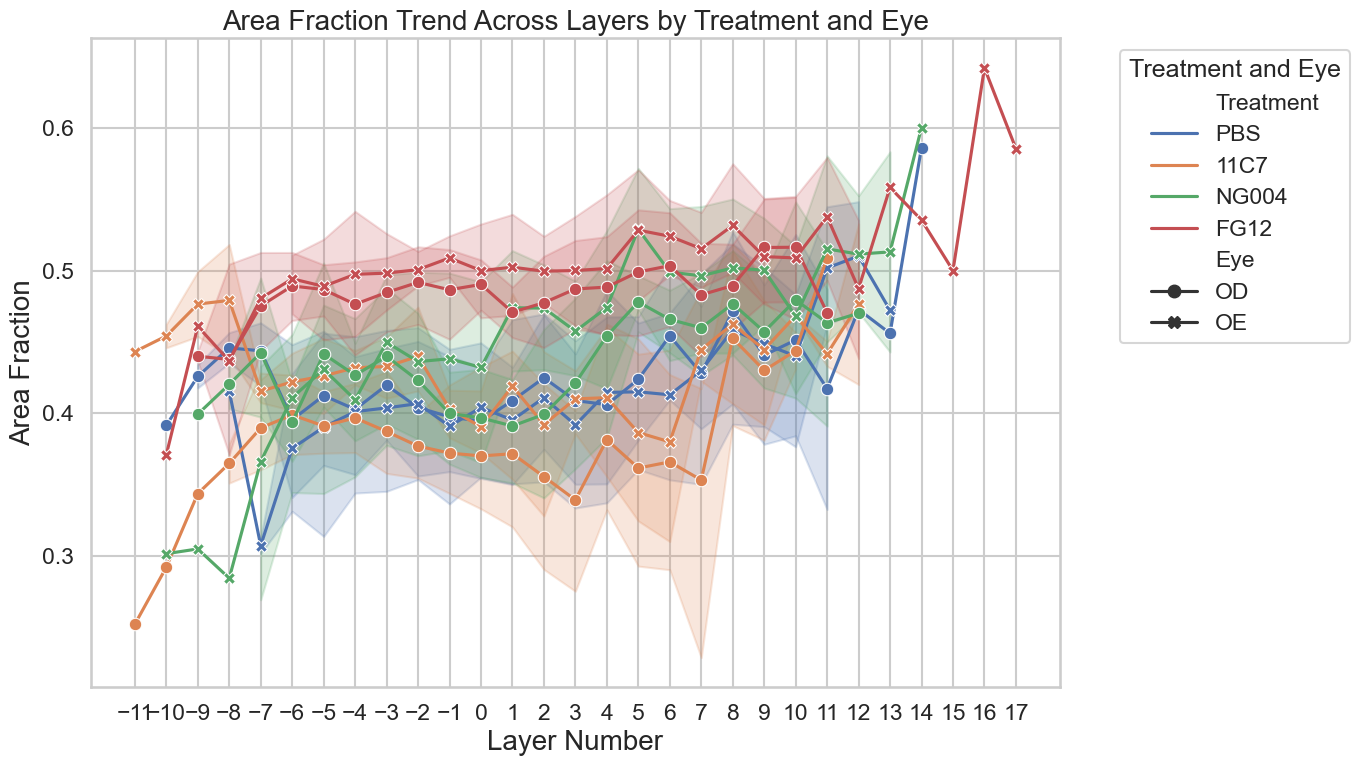

In [24]:
plt.figure(figsize=(14, 8))
sns.lineplot(x="LayerNumber", y="LeakageFrac", hue="Treatment", style="Eye", markers=True, dashes=False, data=df)
plt.title('Area Fraction Trend Across Layers by Treatment and Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)
plt.xticks(np.arange(min(df['LayerNumber']), max(df['LayerNumber'])+1, 1.0))

plt.legend(title='Treatment and Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


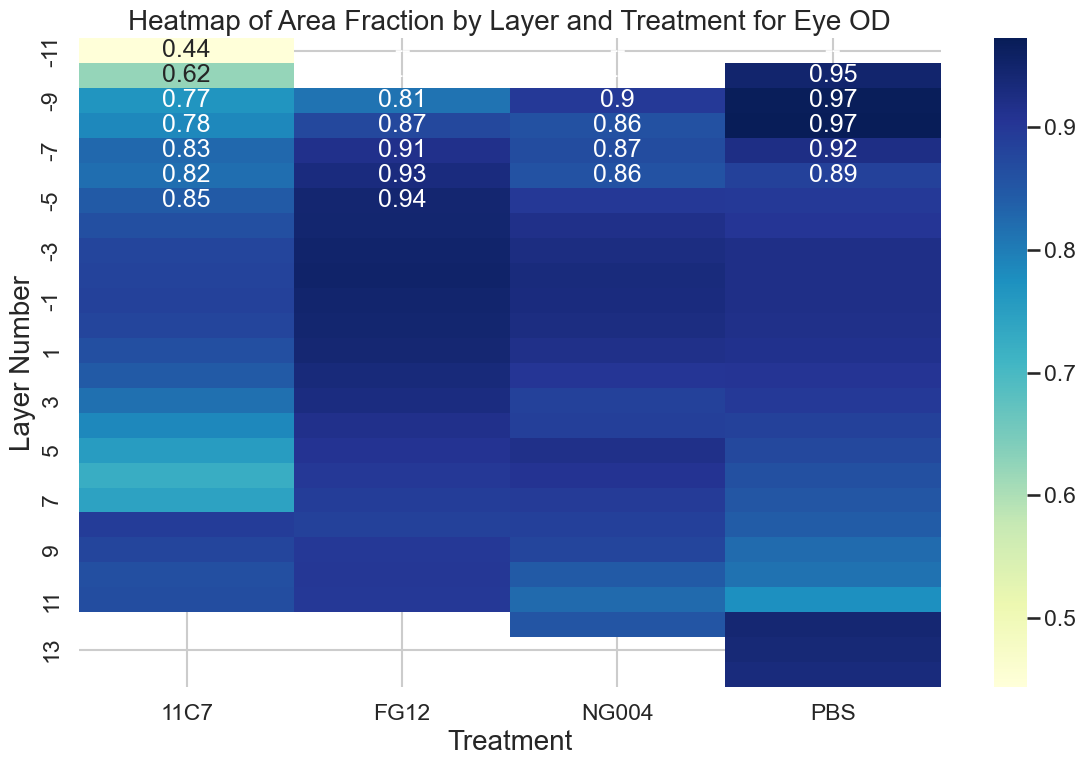

In [8]:
heatmap_data = df[df['Eye'] == 'OD'].pivot_table(index='LayerNumber', columns='Treatment', values='LeakageFrac', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Area Fraction by Layer and Treatment for Eye OD', fontsize=20)
plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Layer Number', fontsize=20)
plt.tight_layout()
plt.show()


## Plots by treatment

c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


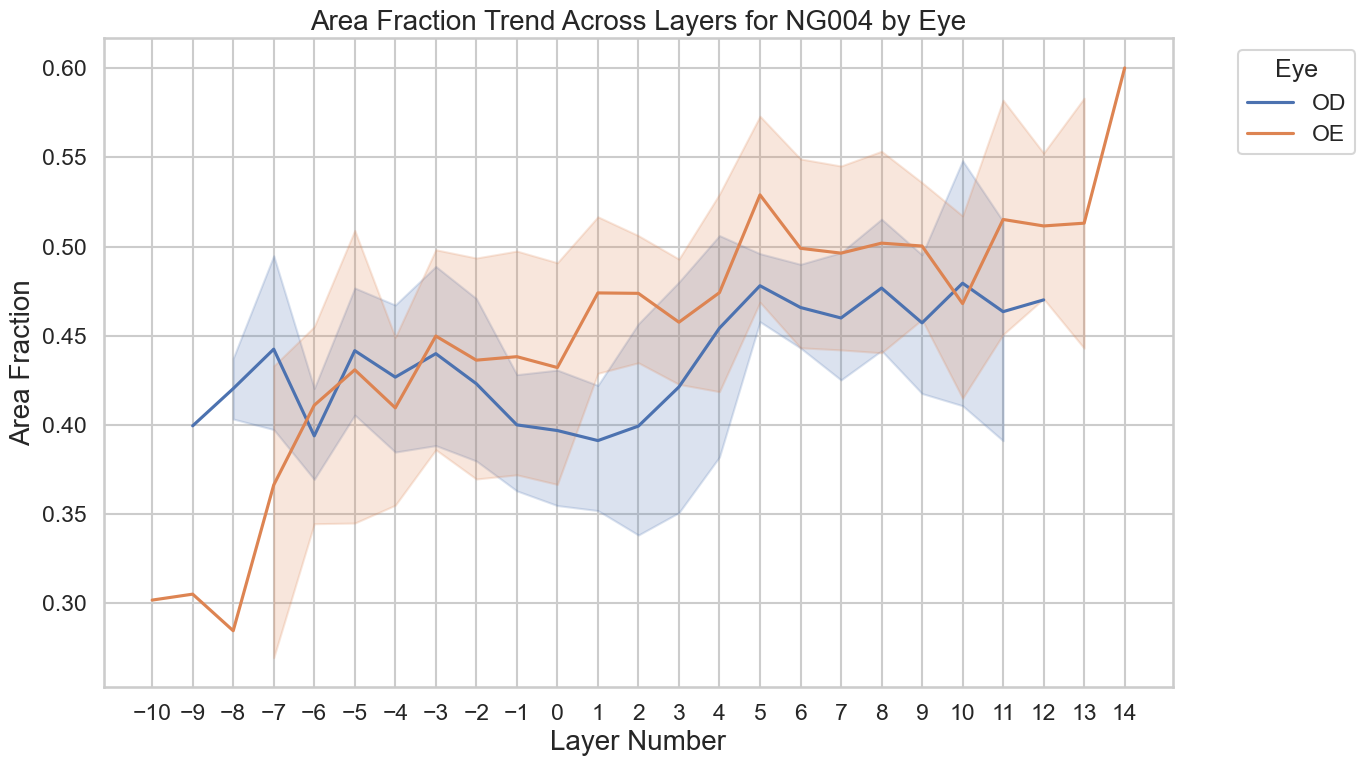

In [25]:
import numpy as np
treatment = 'NG004'
df_filtered = df[df['Treatment'] == treatment]

plt.figure(figsize=(14, 8))
sns.lineplot(x="LayerNumber", y="LeakageFrac", hue="Eye", markers=True, dashes=False, data=df_filtered)
plt.title(f'Area Fraction Trend Across Layers for {treatment} by Eye', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)
plt.legend(title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(np.arange(min(df_filtered['LayerNumber']), max(df_filtered['LayerNumber'])+1, 1.0))

plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


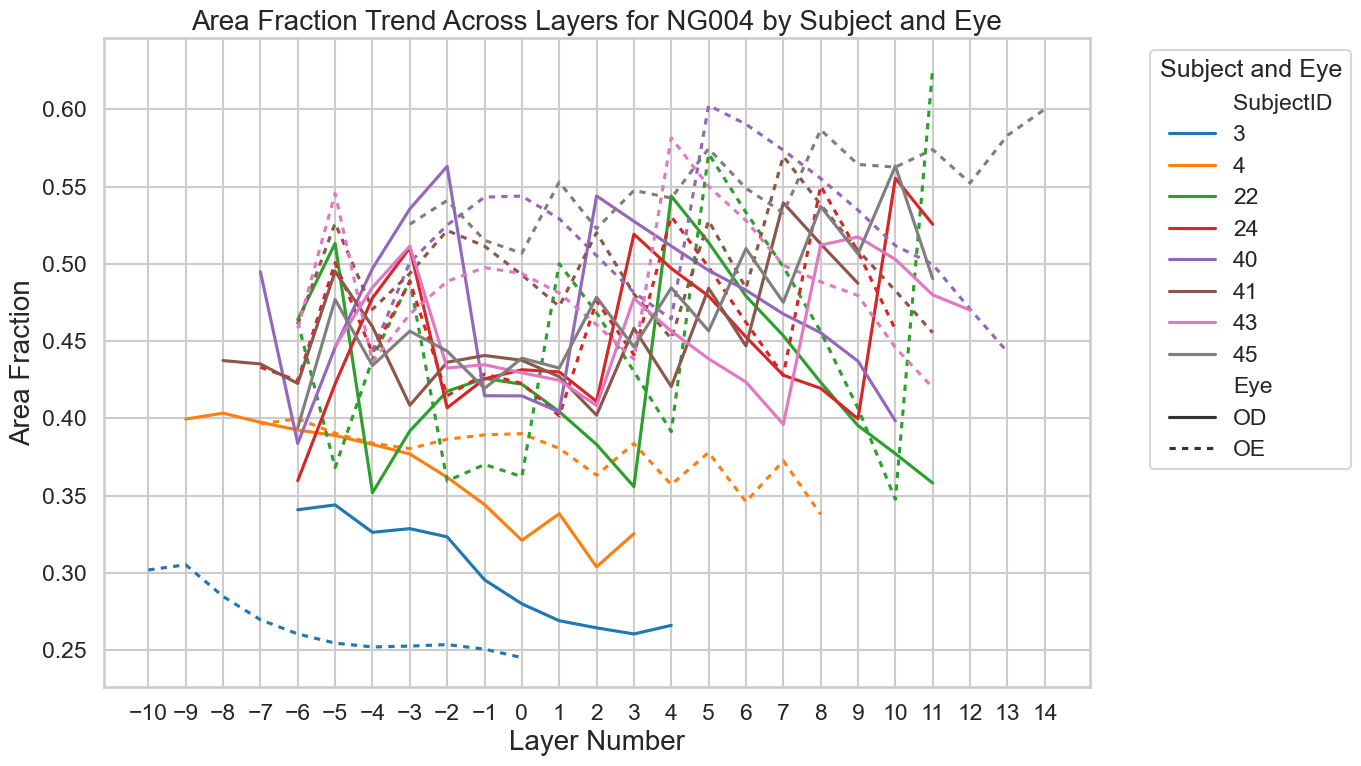

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


treatment = 'NG004'
df_filtered = df[df['Treatment'] == treatment]

plt.figure(figsize=(14, 8))

style_order = ["OD", "OE"]
dashes = {'OD': '', 'OE': (2, 2)}  


sns.lineplot(x="LayerNumber", y="LeakageFrac", hue="SubjectID", style="Eye",
             dashes=dashes, data=df_filtered, palette="tab10", style_order=style_order)

plt.title(f'Area Fraction Trend Across Layers for {treatment} by Subject and Eye', fontsize=20)
plt.xticks(np.arange(min(df_filtered['LayerNumber']), max(df_filtered['LayerNumber'])+1, 1.0))

plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Area Fraction', fontsize=20)

plt.legend(title='Subject and Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Delta OD-OE

In [10]:
df_filtered = df.dropna(subset=['LeakageFrac'])
df_pivot = df_filtered.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'], columns='Eye', values='LeakageFrac').reset_index()
df_pivot['LeakageFractionDiff'] = df_pivot['OD'] - df_pivot['OE']
df_diff = df_pivot.melt(id_vars=['SubjectID', 'Treatment', 'LayerNumber'], value_vars=['LeakageFractionDiff'], 
                        var_name='Metric', value_name='LeakageFrac').dropna()

df_diff = df_diff[['SubjectID', 'Treatment', 'LayerNumber', 'LeakageFrac']]
df_diff['DeltaLeakageFraction'] = df_diff['LeakageFrac']


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


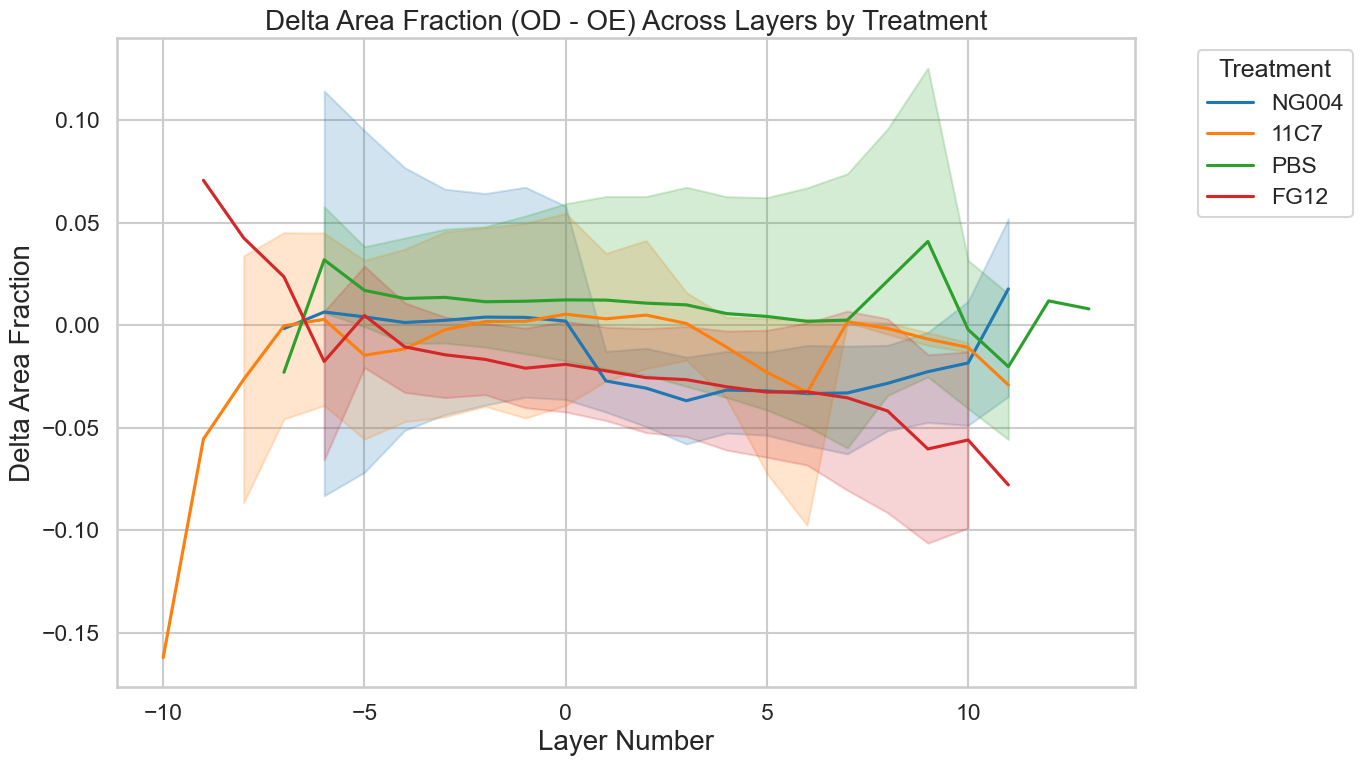

In [11]:
plt.figure(figsize=(14, 8))

sns.lineplot(x="LayerNumber", y="DeltaLeakageFraction", hue="Treatment", data=df_diff, markers=True, dashes=False, palette='tab10')

plt.title('Delta Area Fraction (OD - OE) Across Layers by Treatment', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Delta Area Fraction', fontsize=20)
plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


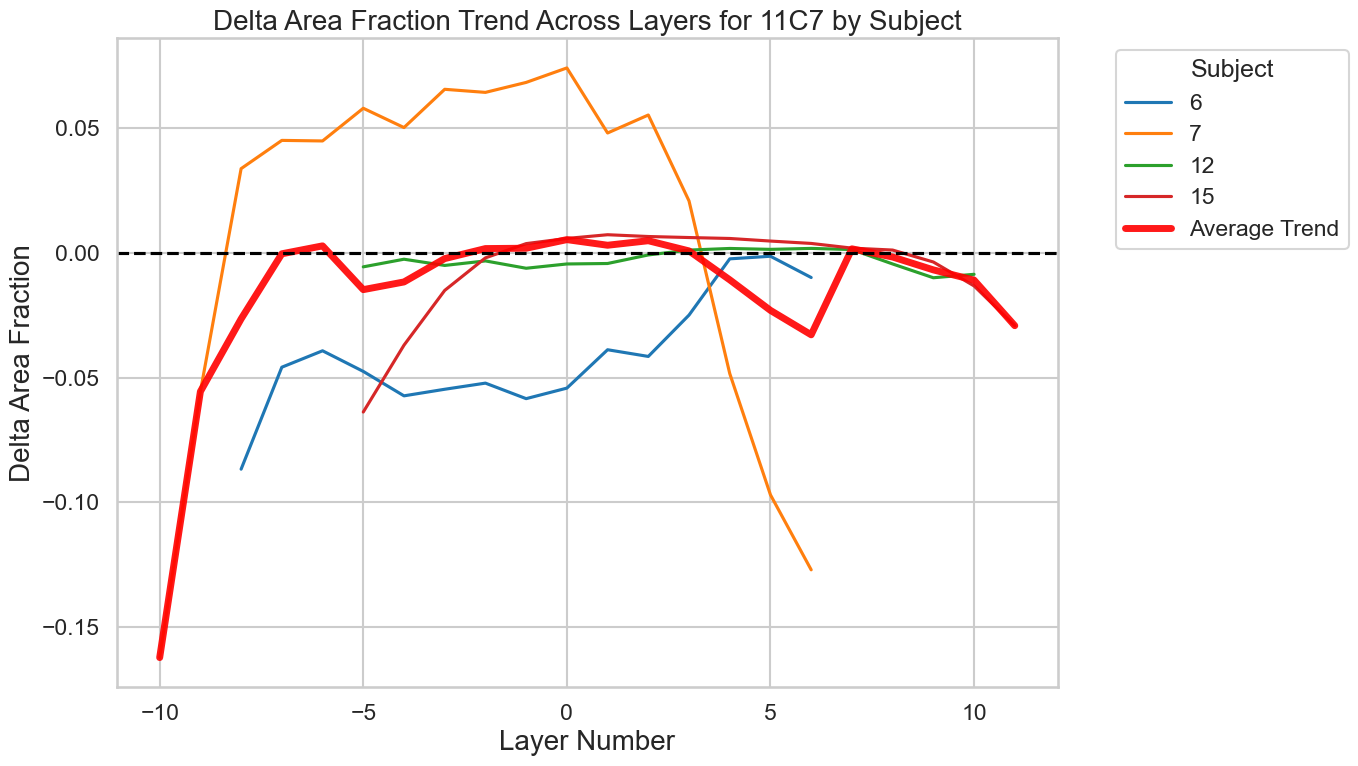

In [13]:
treatment = '11C7'
df_filtered = df_diff[df_diff['Treatment'] == treatment]

plt.figure(figsize=(14, 8))

sns.lineplot(x="LayerNumber", y="DeltaLeakageFraction", hue="SubjectID", markers=True, dashes=False,
             data=df_filtered, palette="tab10")

average_trend = df_filtered.groupby("LayerNumber")["DeltaLeakageFraction"].mean()

plt.plot(average_trend.index, average_trend.values, color='red', linewidth=5, alpha=0.9, label='Average Trend')

plt.title(f'Delta Area Fraction Trend Across Layers for {treatment} by Subject', fontsize=20)
plt.xlabel('Layer Number', fontsize=20)
plt.ylabel('Delta Area Fraction', fontsize=20)

plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


# Comparison by groups of layers

Median 'LeakageFrac' values by 'Treatment' and 'Eye':
  Treatment Eye  LeakageFrac
0      11C7  OD     0.353295
1      11C7  OE     0.413562
2      FG12  OD     0.490822
3      FG12  OE     0.496922
4     NG004  OD     0.418468
5     NG004  OE     0.478539
6       PBS  OD     0.416461
7       PBS  OE     0.412425


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\

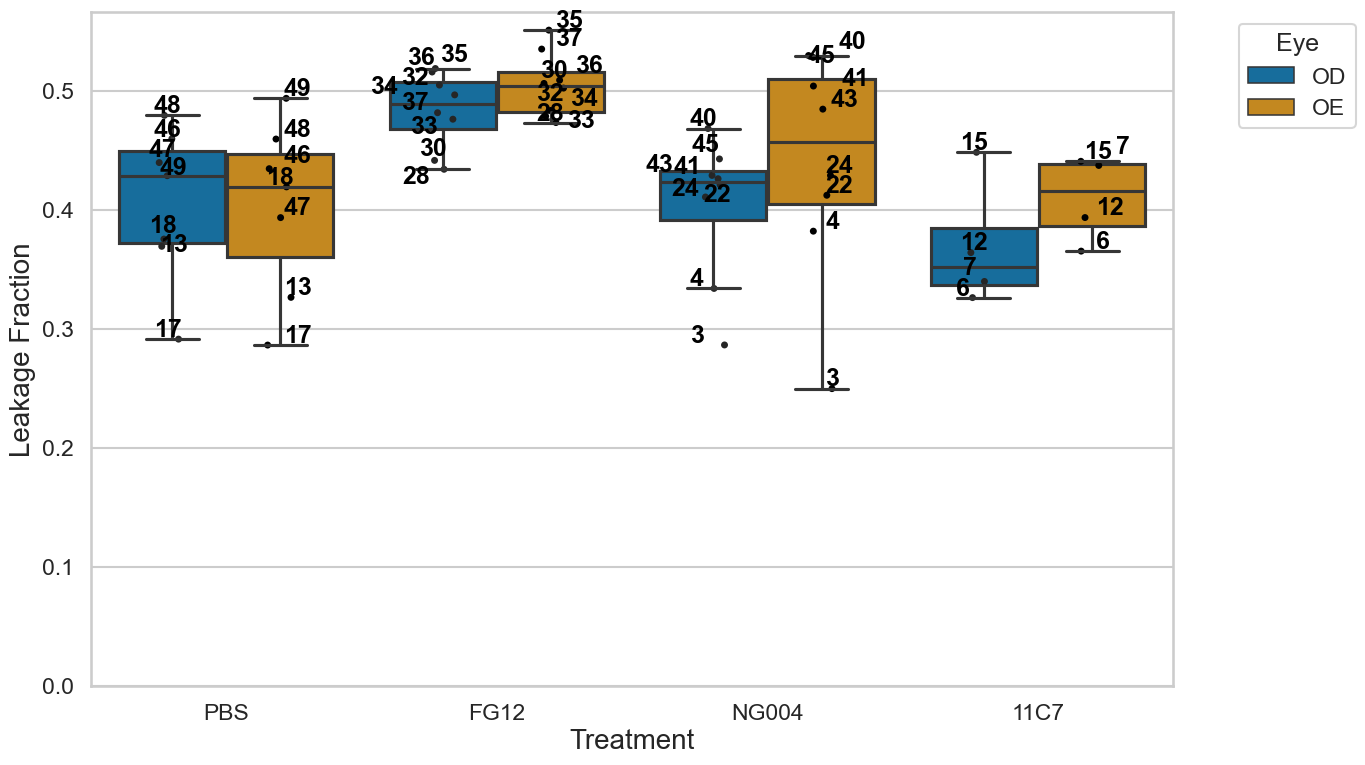

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text


layers_of_interest = [-2, -1, 0, 1, 2]
df_layers = df[df['LayerNumber'].isin(layers_of_interest)]

df_mean_area = df_layers.groupby(['SubjectID', 'Eye', 'Treatment']).agg({'LeakageFrac': 'mean'}).reset_index()

treatment_order = ['PBS', 'FG12', 'NG004', '11C7']

df_mean_area['Treatment'] = pd.Categorical(df_mean_area['Treatment'], categories=treatment_order, ordered=True)

df_median_area = df_layers.groupby(['Treatment', 'Eye'])['LeakageFrac'].median().reset_index()
print("Median 'LeakageFrac' values by 'Treatment' and 'Eye':")
print(df_median_area)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

box_plot = sns.boxplot(x="Treatment", y="LeakageFrac", hue="Eye", data=df_mean_area, palette="colorblind", showfliers=False, order=treatment_order)
strip_plot = sns.stripplot(x="Treatment", y="LeakageFrac", hue="Eye", data=df_mean_area, dodge=True, jitter=0.1, marker='o', color='black', size=5, zorder=1, order=treatment_order)

texts = []
for line in range(0, df_mean_area.shape[0]):
    point = plt.text(
        x=df_mean_area['Treatment'].cat.codes[line] + (-0.25 if df_mean_area['Eye'][line] == 'OD' else 0.25),  # Position offset
        y=df_mean_area['LeakageFrac'][line],
        s=df_mean_area['SubjectID'][line],  # The label to add
        horizontalalignment='center',
        size='medium',
        color='black',
        weight='semibold'
    )
    texts.append(point)

adjust_text(texts)

handles, labels = box_plot.get_legend_handles_labels()
plt.ylim(0)
plt.legend(handles[:2], labels[:2], title='Eye', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Leakage Fraction', fontsize=20)
plt.tight_layout()
plt.show()


C:\Users\alois\AppData\Local\Temp\ipykernel_19276\981938560.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_median_values = df_mean_ratios.groupby('Treatment')['Ratio_OD_OE'].median().reset_index()
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na

Median 'Ratio OD/OE' values by 'Treatment':
  Treatment  Ratio_OD_OE
0       PBS     1.046047
1      FG12     0.985130
2     NG004     0.883569
3      11C7     0.910886


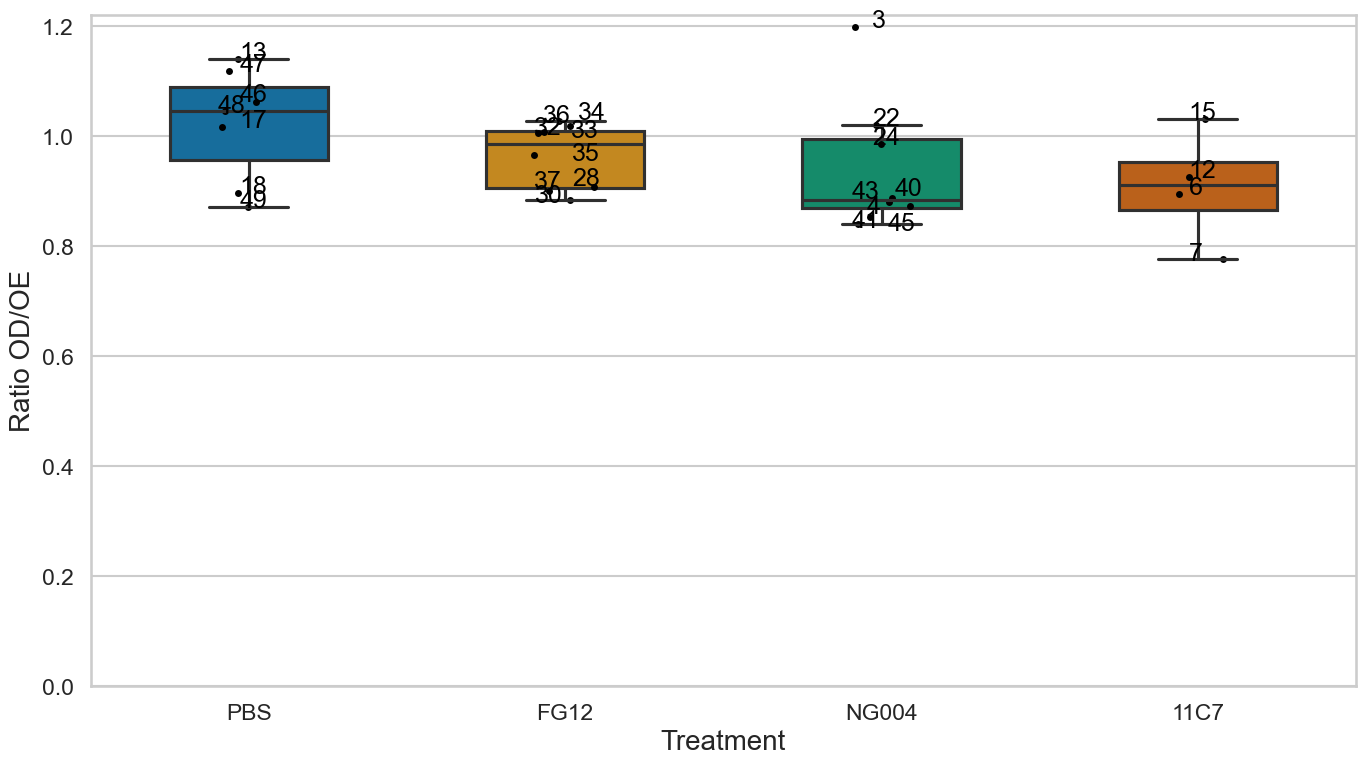

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text


layers_of_interest = [-2, -1, 0, 1, 2]
df_layers = df[df['LayerNumber'].isin(layers_of_interest)]

df_layer_pivot = df_layers.pivot_table(index=['SubjectID', 'Treatment', 'LayerNumber'], columns='Eye', values='LeakageFrac').reset_index()
df_layer_pivot.columns = ['SubjectID', 'Treatment', 'LayerNumber', 'LeakageFrac_OD', 'LeakageFrac_OE']

df_layer_pivot['Ratio_OD_OE'] = df_layer_pivot['LeakageFrac_OD'] / df_layer_pivot['LeakageFrac_OE']
df_layer_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)  # Cleaning up any infinite or NaN values from zero division

df_mean_ratios = df_layer_pivot.groupby(['SubjectID', 'Treatment']).agg({'Ratio_OD_OE':'mean'}).reset_index()

treatment_order = ['PBS', 'FG12', 'NG004', '11C7']

df_mean_ratios['Treatment'] = pd.Categorical(df_mean_ratios['Treatment'], categories=treatment_order, ordered=True)

df_median_values = df_mean_ratios.groupby('Treatment')['Ratio_OD_OE'].median().reset_index()
print("Median 'Ratio OD/OE' values by 'Treatment':")
print(df_median_values)

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", context="talk")

box_plot = sns.boxplot(x="Treatment", y="Ratio_OD_OE", data=df_mean_ratios, palette="colorblind", showfliers=False, width=0.5, order=treatment_order)
strip_plot = sns.stripplot(x="Treatment", y="Ratio_OD_OE", data=df_mean_ratios, jitter=0.1, marker='o', color='black', size=5, zorder=1, order=treatment_order)

texts = []
for index, row in df_mean_ratios.iterrows():
    x_position = treatment_order.index(row['Treatment'])  # Adjust x position based on specified order
    texts.append(plt.text(x=x_position, y=row['Ratio_OD_OE'], s=row['SubjectID'], color='black', ha='center', va='bottom'))

adjust_text(texts)
plt.ylim(0)
plt.xlabel('Treatment', fontsize=20)
plt.ylabel('Ratio OD/OE', fontsize=20)

plt.tight_layout()
plt.show()


# AUC

In [63]:
import pandas as pd
import numpy as np
from scipy.integrate import trapz


treatment_mapping = df[['SubjectID', 'Treatment']].drop_duplicates().set_index('SubjectID')


df_OD = df[df['Eye'] == 'OD']
df_OE = df[df['Eye'] == 'OE']

common_layers = df.groupby(['SubjectID', 'Eye'])['LayerNumber'].max().unstack().min(axis=1)

aucs = {}
for subject_id, min_layers in common_layers.items():
    for eye_type, df_eye in {'OD': df_OD, 'OE': df_OE}.items():
        subject_data = df_eye[(df_eye['SubjectID'] == subject_id) &
                              (df_eye['LayerNumber'] <= min_layers)]
        subject_data = subject_data.sort_values('LayerNumber')
        auc = trapz(subject_data['LeakageFrac'], subject_data['LayerNumber'])
        aucs[(subject_id, eye_type)] = auc

fold_changes = {}
for subject_id in common_layers.index:
    fold_change = aucs[(subject_id, 'OD')] / aucs[(subject_id, 'OE')]
    fold_changes[subject_id] = fold_change

df_fold_changes = pd.DataFrame(list(fold_changes.items()), columns=['SubjectID', 'FoldChangeAUC'])

df_fold_change = df_fold_changes.merge(treatment_mapping, left_on='SubjectID', right_index=True)


c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


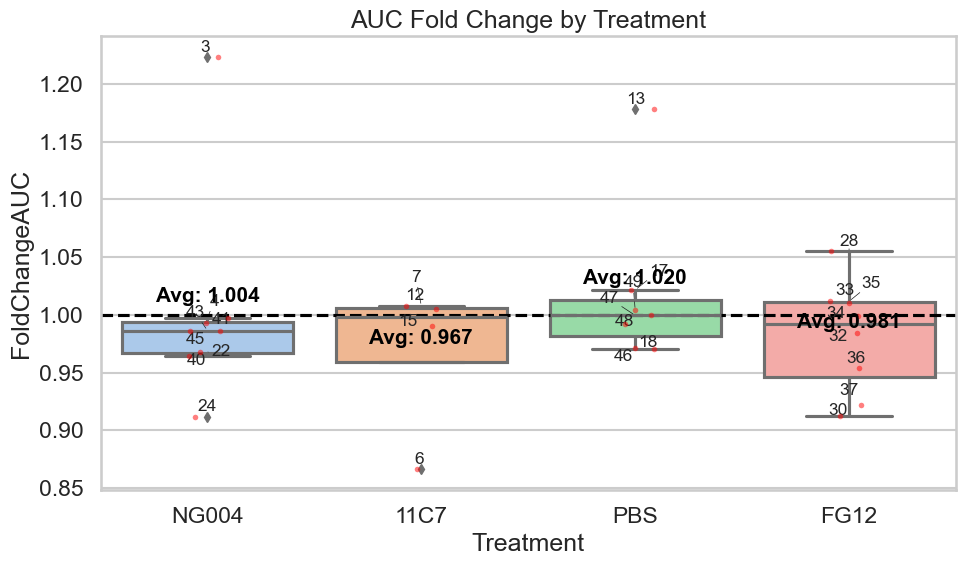

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text


plt.figure(figsize=(10, 6))
sns.boxplot(x='Treatment', y='FoldChangeAUC', data=df_fold_change, palette='pastel')

texts = []

for treatment in df_fold_change['Treatment'].unique():
    subset = df_fold_change[df_fold_change['Treatment'] == treatment]
    for _, row in subset.iterrows():
        x = np.where(df_fold_change['Treatment'].unique() == treatment)[0][0]
        y = row['FoldChangeAUC']
        text = plt.text(x, y, row['SubjectID'], ha='center', va='bottom', size='x-small')
        texts.append(text)

sns.stripplot(x='Treatment', y='FoldChangeAUC', data=df_fold_change, color="red", jitter=True, dodge=True, size=4, alpha=0.5)

average_auc_treatment = df_fold_change.groupby('Treatment')['FoldChangeAUC'].mean()
max_auc = df_fold_change['FoldChangeAUC'].max()
y_offset = (max_auc - df_fold_change['FoldChangeAUC'].min()) * 0.02  

for i, treatment in enumerate(df_fold_change['Treatment'].unique()):
    avg_auc = average_auc_treatment[treatment]
    plt.text(i, avg_auc + y_offset, f'Avg: {avg_auc:.3f}', 
             horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title('AUC Fold Change by Treatment')
plt.ylabel('FoldChangeAUC')
plt.xlabel('Treatment')
plt.axhline(1, color='black', linestyle='--')

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.tight_layout()
plt.show()



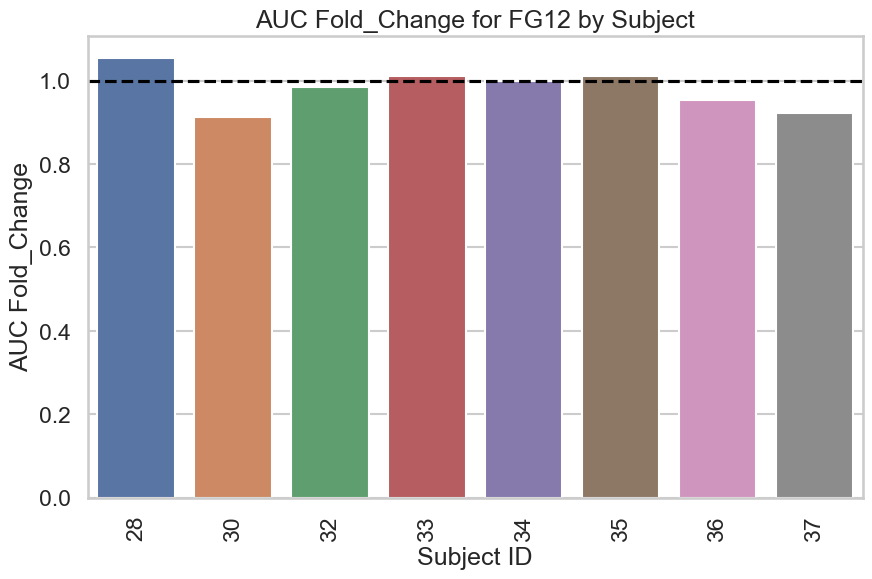

In [65]:
treatment = 'FG12'


df_auc_diff_treatment1 = df_fold_change[df_fold_change['Treatment'] == treatment]

plt.figure(figsize=(10, 6))
sns.barplot(x='SubjectID', y='FoldChangeAUC', data=df_auc_diff_treatment1)
plt.title(f'AUC Fold_Change for {treatment} by Subject')
plt.ylabel('AUC Fold_Change')
plt.xlabel('Subject ID')
plt.axhline(1, color='black', linestyle='--')


plt.xticks(rotation=90)
plt.show()

# Ratio OD/OE for maximum

In [66]:
max_area = df.loc[df.groupby(['Treatment', 'SubjectID', 'Eye'])['LeakageFrac'].idxmax()]
pivot_df = max_area.pivot_table(index=['Treatment', 'SubjectID'], columns='Eye', values='LeakageFrac').reset_index()

pivot_df['Ratio'] = pivot_df['OD'] / pivot_df['OE']

df_ratio = pivot_df[['Treatment', 'SubjectID', 'Ratio']]

c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alois\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


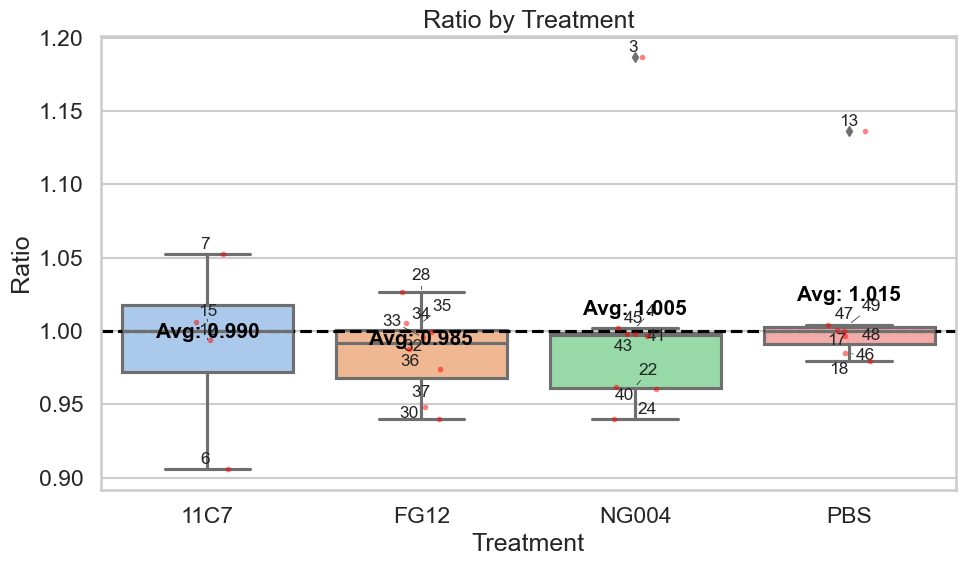

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
sns.boxplot(x='Treatment', y='Ratio', data=df_ratio, palette='pastel')

texts = []

for treatment in df_ratio['Treatment'].unique():
    subset = df_ratio[df_ratio['Treatment'] == treatment]
    for _, row in subset.iterrows():
        x = np.where(df_ratio['Treatment'].unique() == treatment)[0][0]
        y = row['Ratio']
        text = plt.text(x, y, row['SubjectID'], ha='center', va='bottom', size='x-small')
        texts.append(text)

sns.stripplot(x='Treatment', y='Ratio', data=df_ratio, color="red", jitter=True, dodge=True, size=4, alpha=0.5)

average_ratio_treatment = df_ratio.groupby('Treatment')['Ratio'].mean()
max_ratio = df_ratio['Ratio'].max()
y_offset = (max_ratio - df_ratio['Ratio'].min()) * 0.02  

for i, treatment in enumerate(df_ratio['Treatment'].unique()):
    avg_ratio = average_ratio_treatment[treatment]
    plt.text(i, avg_ratio + y_offset, f'Avg: {avg_ratio:.3f}', 
             horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title('Ratio by Treatment')
plt.ylabel('Ratio')
plt.xlabel('Treatment')
plt.axhline(1, color='black', linestyle='--')

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.tight_layout()
plt.show()



# Entropy selection evaluation

In [ ]:

df_max = df.loc[df.groupby(['SubjectID', 'Eye', 'Treatment'])['LeakageFrac'].idxmax()]
df_max = df_max[['Treatment','SubjectID', 'Eye', 'LayerNumber', 'LeakageFrac']]
df_max['SubjectID'] = df_max['SubjectID'].astype('int64')


In [ ]:


import re


folders = ['PBS', 'FG12', 'NG004', '11C7']

data = []

pattern = r"Akita(?P<SubjectID>\d+)_(?P<Eye>OD|OE)_25x_stack_(?P<LayerNumber>\d+).tif"

for treatment in folders:
    folder_path = os.path.join('data', treatment)
    
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if re.match(pattern, file) and 'contrast' not in file:
                match = re.match(pattern, file)
                if match:
                    data.append({
                        'Treatment': treatment,
                        'SubjectID': match.group('SubjectID'),
                        'Eye': 'OD' if match.group('Eye') == 'OD' else 'OE',
                        'LayerNumber': int(match.group('LayerNumber')),
                    })

df_entropy = pd.DataFrame(data)
df_entropy['SubjectID'] = df_entropy['SubjectID'].astype('int64')



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



merged_df = pd.merge(df_entropy, df_max, on=['SubjectID', 'Eye'], suffixes=('_entropy', '_max'))

merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['LayerDifference'], kde=True)
plt.title('Distribution of Layer Differences')
plt.xlabel('Difference in Layer Number')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='LayerNumber_entropy', y='LayerNumber_max', data=merged_df)
plt.title('Entropy Layer Selection vs. Max LeakageFrac Layer')
plt.xlabel('Layer Number (Entropy Selection)')
plt.ylabel('Layer Number (Max LeakageFrac)')
plt.show()




In [ ]:
grouped_diff = merged_df.groupby(['Treatment_max', 'Eye'])['LayerDifference'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.boxplot(x='Treatment_max', y='LayerDifference', hue='Eye', data=merged_df, palette='coolwarm')
plt.title('Distribution of Layer Differences by Treatment and Eye')
plt.xlabel('Treatment')
plt.ylabel('Layer Difference')
plt.axhline(0, color='gray', linestyle='--')  # Adds a reference line at 0 difference
plt.legend(title='Eye')
plt.show()


In [ ]:
std_dev = np.std(merged_df['LayerDifference'])

n = len(merged_df['LayerDifference'])

std_error = std_dev / np.sqrt(n)

print(f"Standard Error of the Layer Differences: {std_error}")

In [ ]:
import numpy as np

grouped_stats = merged_df.groupby(['Treatment', 'Eye'])['LayerDifference'].agg(['std', 'count']).reset_index()

grouped_stats['SE'] = grouped_stats['std'] / np.sqrt(grouped_stats['count'])

grouped_stats.rename(columns={'std': 'Standard Deviation', 'count': 'Count', 'SE': 'Standard Error'}, inplace=True)
print(grouped_stats[['Treatment', 'Eye', 'Standard Deviation', 'Count', 'Standard Error']])




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Treatment_max', y='LayerDifference', data=merged_df)
plt.title('Distribution of Layer Selection Differences by Treatment')
plt.xlabel('Treatment')
plt.ylabel('Layer Selection Difference')
plt.show()


# Evaluation of entropy selection

In [ ]:


df_entropy['Eye'] = df_entropy['Eye'].replace({'OD': 'Right', 'OE': 'Left'})
df_max['Eye'] = df_max['Eye'].replace({'OD': 'Right', 'OE': 'Left'})

merged_df = pd.merge(df_entropy, df_max, on=['SubjectID', 'Eye', 'Treatment'], suffixes=('_entropy', '_max'))


In [ ]:
merged_df['AbsLayerDifference'] = (merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']).abs()
merged_df['LayerDifference'] = merged_df['LayerNumber_entropy'] - merged_df['LayerNumber_max']
mad_by_treatment = merged_df.groupby('Treatment')['AbsLayerDifference'].mean().reset_index()

print("Mean Absolute Difference by Treatment:")
print(mad_by_treatment)


In [ ]:

layer_counts = merged_df.groupby(['LayerNumber_entropy', 'LayerNumber_max']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(layer_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap of Layer Selection Frequencies')
plt.xlabel('Max LeakageFrac Layer Number')
plt.ylabel('Entropy Layer Number')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='LayerNumber_entropy', y='LayerNumber_max', data=merged_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Entropy Layer Selection vs. Max LeakageFrac Layer Selection')
plt.xlabel('Layer Number (Entropy Selection)')
plt.ylabel('Layer Number (Max LeakageFrac Selection)')
plt.show()


In [ ]:
correlation = merged_df['AbsLayerDifference'].corr(merged_df['LeakageFrac'])
print(f"Pearson Correlation Coefficient: {correlation}")
